# Transform a continuous PPG signal into an image
### The preprocessing of a neural network classification application
Operate on a window of PPG signal.
### Import libraries and packages

In [1]:
import os
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

### Import vitalSQI

In [2]:
from vital_sqi.data.signal_io import PPG_reader
import vital_sqi.highlevel_functions.highlevel as sqi_hl
import vital_sqi.data.segment_split as sqi_sg
from vital_sqi.common.rpeak_detection import PeakDetector

### Data path

In [3]:
patient = '2001'
filepath = 'D:/IC Final Year Project/OUCRU/adults/01NVa-003-' + patient + '/PPG'
filename = '01NVa-003-2001 Smartcare.csv'

### Global variables

In [4]:
sampling_rate = 100  # Hz
hp_filt_params = (1, 1)  # (Hz, order)
lp_filt_params = (20, 4)  # (Hz, order)
filter_type = 'butter'
trim_amount = 20  # s
# segment_length = 30  # s
# window specification
width = 128  # image width
height = 128  # image height

### Load and prepare the PPG data

In [5]:
# just use the data from column 'PLETH'
ppg_data = PPG_reader(os.path.join(filepath, filename),
                      signal_idx=['PLETH'],
                      timestamp_idx=['TIMESTAMP_MS'],
                      info_idx=['SPO2_PCT', 'PULSE_BPM', 'PERFUSION_INDEX'],
                      timestamp_unit='ms', sampling_rate=sampling_rate, start_datetime=None)

raw_signal = np.copy(
    ppg_data.signals.T[trim_amount * sampling_rate:-trim_amount * sampling_rate].T)  # save the raw signal

# a window from the raw signal of length 16384 = 128 * 128
window = raw_signal[0, 0:width*height]

## 1. Directly convert the raw signal into an image *img1*

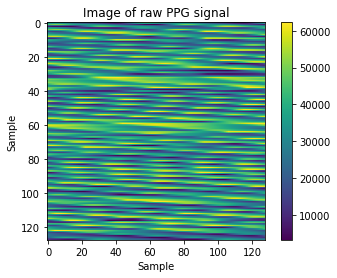

In [6]:
ppg_len = raw_signal.shape[1]
img1 = np.reshape(window, (height, width))
plt.imshow(img1)
plt.title('Image of raw PPG signal')
plt.xlabel('Sample')
plt.ylabel('Sample')
plt.colorbar()
plt.show()

The periodicity comes from the pulses of the raw data.

## 2. Calculate the spectrogram of a window

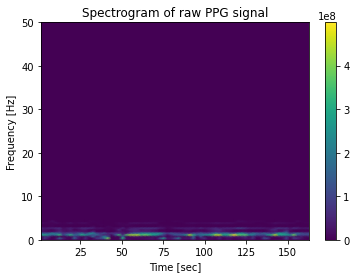

In [7]:
f, t, Sxx = signal.spectrogram(window, fs=sampling_rate)
img2 = Sxx
plt.pcolormesh(t, f, img2, shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.title('Spectrogram of raw PPG signal')
plt.colorbar()
plt.show()

## 3. 2-D FFT of *img1*

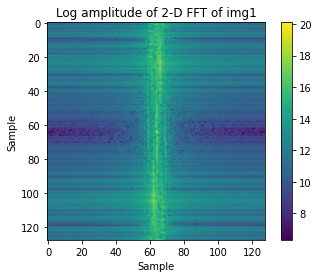

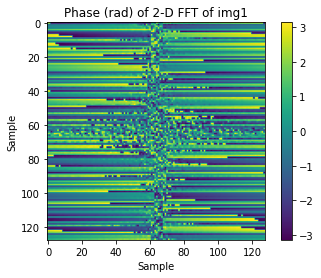

In [8]:
img1fft = np.fft.fft2(img1)
# Shift the zero-frequency component to the center of the spectrum.
img3 = np.fft.fftshift(img1fft)
plt.figure()
plt.imshow(np.log(abs(img3)))
plt.title('Log amplitude of 2-D FFT of img1')
plt.xlabel('Sample')
plt.ylabel('Sample')
plt.colorbar()
plt.show()

plt.figure()
plt.imshow(np.angle(img3))
plt.title('Phase (rad) of 2-D FFT of img1')
plt.xlabel('Sample')
plt.ylabel('Sample')
plt.colorbar()
plt.show()

## 4. 1-D FFT of a window then reshape to an image

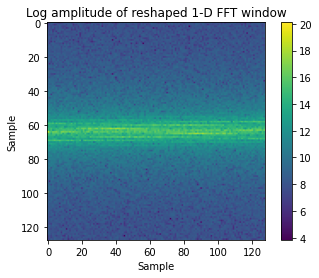

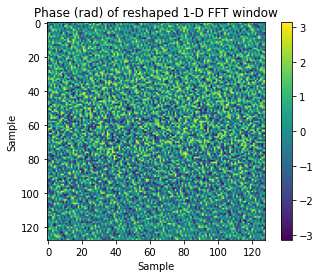

In [9]:
windowfft = np.fft.fft(window)
# Shift the zero-frequency component to the center of the spectrum.
windowfft = np.fft.fftshift(windowfft)
img4 = np.reshape(windowfft, (height, width))
plt.figure()
plt.imshow(np.log(abs(img4)))
plt.title('Log amplitude of reshaped 1-D FFT window')
plt.xlabel('Sample')
plt.ylabel('Sample')
plt.colorbar()
plt.show()

plt.figure()
plt.imshow(np.angle(img4))
plt.title('Phase (rad) of reshaped 1-D FFT window')
plt.xlabel('Sample')
plt.ylabel('Sample')
plt.colorbar()
plt.show()

## 5. Form an image of SQIs
One image for each window, and different images have the same SQIs in corresponding positions. Different SQIs
take different areas (large or small).

